In [1]:
%cd ..

/Users/rcap/Projects/embdi


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gensim.models as models
import networkx as nx
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import os
import EmbDI.edgelist as edgelist

In [3]:
from importlib import reload
import demo_utils as du
reload(du)
from demo_utils import *

# EmbDI: Embeddings for Data Integration

## Representing relational datasets as graphs.

In [4]:
# Reading the input dataset and preparing the edge list. 
dfpath = './pipeline/demo_files/imdb_movielens-master.csv'
df = pd.read_csv(dfpath)
# IMDB
df1 = pd.read_csv('./pipeline/demo_files/imdb_movielens-tableA.csv')
# Movielens
df2 = pd.read_csv('./pipeline/demo_files/imdb_movielens-tableB.csv')

In [5]:
# print(df1.info())
# print(df2.info())

colset_1 = set(df1.columns)
colset_2 = set(df2.columns)

common_columns = list(colset_1.intersection(colset_2))
cols_only_df1 = colset_1.difference(colset_2)
cols_only_df2 = colset_2.difference(colset_1)

print('Table A and Table B share the following columns:')
for col in common_columns:
    print(col)

print()
print('The following columns are present only in Table A:')
for col in cols_only_df1:
    print(col)

print()
print('The following columns are present only in Table B:')
for col in cols_only_df2:
    print(col)




Table A and Table B share the following columns:
vote_average
year
actor_3
production_countries
actor_2
director
title
original_language
actor_1

The following columns are present only in Table A:
content_rating
color

The following columns are present only in Table B:
status
release_date_rounded
production_companies
genres


In [6]:
%%time
edgefile = 'pipeline/demo_files/imdb_movielens-edges.txt'
# el = edgelist.EdgeList(df, edgefile)

pref = ['3#__tn', '3$__tt','5$__idx', '1$__cid']

el = edgelist.EdgeList(df, edgefile, pref)

# g = Graph(el.get_edgelist(), prefixes=pref)


49875it [00:08, 5977.86it/s]


CPU times: user 8.43 s, sys: 287 ms, total: 8.72 s
Wall time: 8.62 s


In [7]:
g = nx.Graph()
edgefile = 'pipeline/demo_files/imdb_movielens-edges.txt'

with open(edgefile, 'r') as fp:
    for idx, line in enumerate(fp):
        line = line.strip('')
        if len(line) == 0:
            continue
        n1,n2,w1,w2 = line.split(',')
        g.add_edge(n1, n2)        

In [8]:
# Printing the list of neighbors of an actor. 
print('Neighbors of quentin_tarantino:')
print(list(g.neighbors('tt__quentin_tarantino')))
print()
print('Neighbors of idx_1:')
print(list(g.neighbors('idx__1')))


Neighbors of quentin_tarantino:
['idx__285', 'cid__director', 'idx__568', 'idx__681', 'idx__824', 'idx__826', 'idx__876', 'cid__actor_1', 'idx__2158', 'idx__2787', 'idx__3178', 'idx__3286', 'idx__4042', 'idx__4145', 'idx__4598', 'cid__actor_2', 'idx__4821', 'idx__5584', 'idx__6173', 'idx__11248', 'idx__11794', 'idx__15215', 'idx__15285', 'cid__actor_3', 'idx__16390', 'idx__17284', 'idx__18124', 'idx__24555', 'idx__32612', 'idx__45678']

Neighbors of idx_1:
['tt__johnny_depp', 'tt__orlando_bloom', 'tt__jack_davenport', 'tt__color', 'tt__pg13', 'tt__gore_verbinski', 'tt__english', 'tt__usa', 'tt__pirates_of_the_caribbean_at_worlds_end', 'tn__7', 'tn__2007']


"quentin_tarantino" is present in multiple "actor" columns and in many different tuples. To show these tuples, we take a small subset and induce a subgraph by selecting all the nodes present in those tuples, as well as all the columns in the starting dataset. 

As an example, we'll take a subset of the graph G by selecting only 3 tuples, corresponding to some of the movies Orlando Bloom starred in.


In [10]:
r1 = list(g.neighbors('idx__3178')) # from dataset 1
r2 = list(g.neighbors('idx__3286')) # from dataset 1
r3 = list(g.neighbors('idx__4821')) # from dataset 2

cids = ['cid__' + _ for _ in  list(df.columns)]

nodes = r1 + r2 + r3 + cids + ['idx__3178', 'idx__3286', 'idx__4821']

subg = g.subgraph(nodes)

left = ['idx__3178', 'idx__3286', 'idx__4821']
right = cids
middle = r1 + r2 + r3
plot_graph(subg, left, middle, right,'pipeline/demo_files/graph.html', title='<br>Network graph on a snippet of imdb_movielens')


FileNotFoundError: [Errno 2] No such file or directory: 'images/pipeline/demo_files/graph.html'

## Training local embeddings on relational data using EmbDI

EmbDI is a system designed to train local embeddings on relational data. To do so, it requires a set of mandatory parameters and optional parameters to be supplied using configuration files with a specific format. 

An example of such configuration file is shown below: it will be used to train some of the embeddings used in the representation at the end of this notebook. For more info on how to prepare the configuration file, please refer to the configuration section in the readme. 

In [5]:
raw_config = '''ntop:10
ncand:1
task:train
input_file:pipeline/experiments/imdb_movielens-edges.txt
dataset_info:pipeline/info/info-imdb_movielens.txt
embeddings_file:pipeline/embeddings/imdb_movielens-demo-500k.embs
output_file:imdb_movielens-demo-500k
flatten:tt
compression:false
n_sentences:500000'''

# EmbDI is expecting a textual file, so the raw configuration is dumped in a suitable text file to be parsed by the system.
with open('pipeline/config_files/imdb_movielens-demo-500k.txt', 'w') as fp:
    fp.write(raw_config)

Now that the configuration file is ready, the system can be ran and embeddings will be trained on the file imdb_movielens-demo-notebook.embs. The dataset currently under observation is quite large, so the training procedure will take some time. 

In [7]:
! python main.py -f pipeline/config_files/imdb_movielens-demo-500k.txt

################################################################################
# File 1 out of 1
# Configuration file: imdb_movielens-demo-500k.txt
# Starting run................................................ 2020-06-05 11:23:08.893071
# Starting graph construction................................. 2020-06-05 11:23:12
# Expanding columns ['tt'].
Loading edgelist_file.: 100%|██████| 1214420/1214420 [00:20<00:00, 59936.77it/s]
Prepare aliased randomizer for each node: 100%|█| 228108/228108 [00:05<00:00, 39

# Graph construction complete................................. 2020-06-05 11:23:38
# Time required to build graph:............................... 26.086527
# Skipping search of overlapping values. 
# Generating basic random walks............................... 2020-06-05 11:23:38
Sentence generation progress: 100%|████| 356436/356436 [27:59<00:00, 212.22it/s]
Completing fraction of random walks: 100%|█| 143564/143564 [16:16<00:00, 147.01i
# Generation of random walks completed.....

In [8]:
walks_file = 'pipeline/walks/imdb_movielens-demo-500k.walks'
with open(walks_file) as fp:
    walk = fp.readline()
    print(walk)

idx__2097 tt__cch idx__2815 tt__tales_from_the_crypt_demon_knight idx__4852 tt__horror idx__14371 tt__en idx__28084 tt__corbin_allred cid__actor_2 tt__saln idx__39503 tt__ulving idx__39503 tt__drowning_ghost cid__title tt__incubus idx__9956 tn__1982 idx__7329 tt__mel_gibson idx__6102 tt__fairytale_a_true_story idx__6102 tt__harvey_keitel idx__8447 tt__kelly_lynch idx__4862 tt__russell idx__44915 tt__r idx__1857 tt__uk idx__1324 tt__howard idx__23083 tt__howard_zieff idx__23083 tt__howard_zieff idx__10355 tt__jamie_lee_curtis idx__5899 tt__kline idx__6085 tt__sigourney_weaver idx__45036 tt__macdougall idx__9413 tt__released idx__26180 tt__released idx__11033 tt__bacon idx__36847 tt__james idx__37020 tt__en idx__9992 tt__gb idx__43190



## Visual representation of the embeddings

To have an idea of how embeddings encode information, it's possible to represent visually the vectors that are generated during the training phase. Normally, the dimensionality of those vectors is very high (100 or 300 dimensions), which makes it harder to notice patters. To circumvent this problem, we reduce the number of dimensions from 300 to 10 and use heatmaps to show the values of the vectors. 

In [65]:
df = pd.read_csv('pipeline/datasets/imdb_movielens/imdb_movielens-master.csv')

In [66]:
embeddings_file = 'pipeline/embeddings/imdb_movielens-demo-500k.emb'
reduced_file = 'pipeline/experiments/imdb_movielens-demo-10.emb'

apply_PCA(embeddings_file, reduced_file, 10)

Written on file pipeline/experiments/imdb_movielens-demo-10.emb.


In [67]:
# Reading the reduced file
reduced_file = 'pipeline/experiments/imdb_movielens-demo-10.emb'

mat, keys = prepare_emb_matrix(reduced_file)

## Applications

### Sources

In [13]:
df.loc[df['title'] == 'avatar']

,actor_1,actor_2,actor_3,color,content_rating,director,genres,original_language,production_companies,production_countries,release_date_rounded,status,title,vote_average,year
0,cch_pounder,joel_david_moore,wes_studi,color,pg13,james_cameron,NaN,english,NaN,usa,NaN,NaN,avatar,8.0,2009.0
19069,sam_worthington,zoe_saldana,sigourney_weaver,NaN,NaN,james_cameron,action,en,ingenious|film|partners,us,200912.0,released,avatar,7.0,2009.0


In [14]:
df1.head()

,color,director,actor 2,actor 1,title,actor 3,original language,production countries,content rating,year,vote average
0,color,james cameron,joel david moore,cch pounder,avatar,wes studi,english,usa,pg-13,2009.0,8.0
1,color,gore verbinski,orlando bloom,johnny depp,pirates of the caribbean: at world's end,jack davenport,english,usa,pg-13,2007.0,7.0
2,color,sam mendes,rory kinnear,christoph waltz,spectre,stephanie sigman,english,uk,pg-13,2015.0,7.0
3,color,christopher nolan,christian bale,tom hardy,the dark knight rises,joseph gordon-levitt,english,usa,pg-13,2012.0,8.0
4,color,andrew stanton,samantha morton,daryl sabara,john carter,polly walker,english,usa,pg-13,2012.0,7.0


In [15]:
df2.head()

,genres,original language,production companies,production countries,status,title,vote average,actor 1,actor 2,actor 3,director,release date rounded,year
0,animation,en,pixar animation studios,us,released,toy story,8.0,tom hanks,tim allen,don rickles,john lasseter,1995-10,1995
1,adventure,en,tristar pictures,us,released,jumanji,7.0,robin williams,jonathan hyde,kirsten dunst,joe johnston,1995-12,1995
2,romance,en,warner bros.,us,released,grumpier old men,6.0,walter matthau,jack lemmon,ann-margret,howard deutch,1995-12,1995
3,comedy,en,twentieth century fox film corporation,us,released,waiting to exhale,6.0,whitney houston,angela bassett,loretta devine,forest whitaker,1995-12,1995
4,comedy,en,sandollar productions,us,released,father of the bride part ii,6.0,steve martin,diane keaton,martin short,charles shyer,1995-02,1995


## Entity Resolution: find the duplicates

In [48]:
df['title'].dropna().loc[df['title'].dropna().str.contains('interstellar')]

95       interstellar
27368    interstellar
Name: title, dtype: object

In [35]:
df['title'].dropna().loc[df['title'].dropna().str.contains('jurassic_park')]

332                jurassic_park_iii
505     the_lost_world_jurassic_park
672                    jurassic_park
5004                   jurassic_park
6000    the_lost_world_jurassic_park
9033               jurassic_park_iii
Name: title, dtype: object

In [54]:
values = ['idx__95', 'idx__27368', 'idx__672', 'idx__5004']
idxes = [int(_.replace('idx__', '')) for _ in values]
labels = df.loc[idxes]['title'].str.replace('_', ' ')
labels = [f'{v[0]} {v[1]}' for v in list(zip(idxes, labels))]
labels

['95 interstellar',
 '27368 interstellar',
 '672 jurassic park',
 '5004 jurassic park']

In [52]:
values = ['idx__2321', 'idx__20572', 'idx__251', 'idx__27416']
labels = [int(_.replace('idx__', '')) for _ in values]
idxes = [int(_.replace('idx__', '')) for _ in values]
df.loc[idxes]

,actor_1,actor_2,actor_3,color,content_rating,director,genres,original_language,production_companies,production_countries,release_date_rounded,status,title,vote_average,year
2321,james_franco,treat_williams,kate_burton,color,r,danny_boyle,NaN,english,NaN,usa,NaN,NaN,127_hours,8.0,2010.0
20572,james_franco,kate_mara,amber_tamblyn,NaN,NaN,danny_boyle,adventure,en,fox|searchlight|pictures,gb,201011.0,released,127_hours,7.0,2010.0
251,eva_green,sullivan_stapleton,peter_mensah,color,r,noam_murro,NaN,english,NaN,usa,NaN,NaN,300_rise_of_an_empire,6.0,2014.0
27416,sullivan_stapleton,eva_green,lena_headey,NaN,NaN,noam_murro,action,en,legendary|pictures,us,201403.0,released,300_rise_of_an_empire,6.0,2014.0


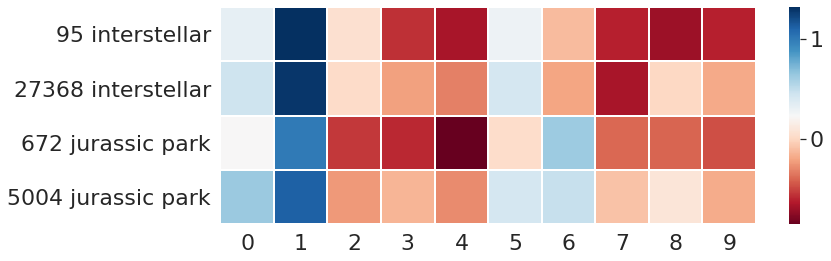

In [56]:
k = []
for _ in values:
    k.append(keys.index(_))

fig = plt.figure(figsize=(12,4))
sns.set(font_scale=2)
g = sns.heatmap(data=mat[k, :], cmap='RdBu', cbar=True, linewidths=1, square=False)
g.set_yticklabels(labels=labels, rotation=0)
fig.savefig('entity_resolution.png', bbox_inches='tight')

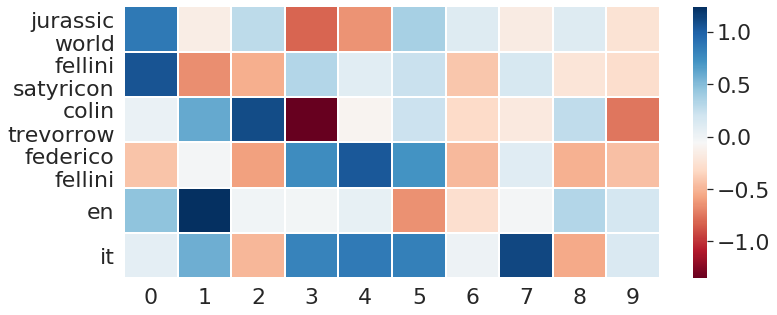

In [82]:
values = ['tt__jurassic_world', 'tt__fellini_satyricon', 'tt__colin_trevorrow', 'tt__federico_fellini', 'tt__en', 'tt__it']
# labels = [_.replace('_', '\n') if len(_) > 10 else _.replace('_', ' ') for _ in values ]
labels = [_.replace('tt__', '').replace('_', '\n') if len(_) > 10 else _.replace('tt__', '').replace('_', ' ') for _ in values ]
k = []
for _ in values:
    k.append(keys.index(_))

fig = plt.figure(figsize=(12,5))
sns.set(font_scale=2.)
g = sns.heatmap(data=mat[k, :], cmap='RdBu', cbar=True, linewidths=1, square=False)
g.set_yticklabels(labels=labels, rotation=0)
fig.savefig('heatmap_values.png', bbox_inches='tight')

In [64]:
values = ['tt__jurassic_world', 'tt__fellini_satyricon', 'tt__la_strada', 'tt__amarcord']
# labels = [_.replace('_', '\n') if len(_) > 10 else _.replace('_', ' ') for _ in values ]
labels = [_.replace('tt__', '').replace('_', '\n') if len(_) > 10 else _.replace('tt__', '').replace('_', ' ') for _ in values ]
k = []
for _ in values:
    k.append(keys.index(_))

fig = plt.figure(figsize=(12,8))
sns.set(font_scale=2.)
g = sns.heatmap(data=mat[k, :], cmap='RdBu', cbar=False, linewidths=1, square=False)
g.set_yticklabels(labels=labels, rotation=0)
fig.savefig('italian_movies_oddoneout2.png', bbox_inches='tight')

ValueError: 'tt__jurassic_world' is not in list

## Schema Matching: concatenate attributes

In [58]:
embeddings_file = 'pipeline/embeddings/imdb_movielens-sm-demo.embs'
reduced_file = 'pipeline/experiments/imdb_movielens-sm-demo-10.emb'


apply_PCA(embeddings_file, reduced_file, 10)

Written on file pipeline/experiments/imdb_movielens-sm-demo-10.emb.


In [59]:
reduced_file = 'pipeline/experiments/imdb_movielens-sm-demo-10.emb'
model_file = reduced_file
mat, keys = prepare_emb_matrix(reduced_file)

df1 = pd.read_csv('pipeline/datasets/imdb_movielens/imdb_movielens-master-sm.csv')

/home/spoutnik23/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning:

Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.



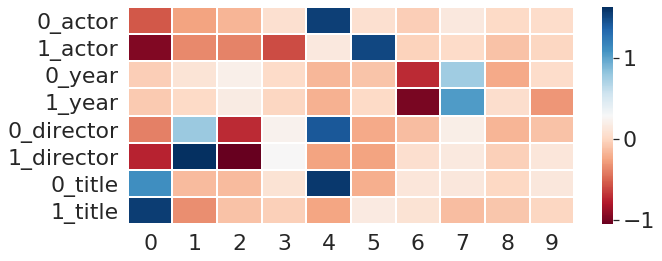

In [63]:
values = ['0_actor_1','1_actor_1', '0_year', '1_year', '0_director', '1_director', '0_title', '1_title']
labels = ['0_actor','1_actor', '0_year', '1_year', '0_director', '1_director', '0_title', '1_title']

# produce_heatmap(keys, values, mat, path='schema_matching_sns.png', rotation=0, refactor=False, labels=labels)
k = []
for _ in values:
    k.append(keys.index(_))

fig = plt.figure(figsize=(10,4))
sns.set(font_scale=2)
g = sns.heatmap(data=mat[k, :], cmap='RdBu', cbar=True, linewidths=1, square=False)
g.set_yticklabels(labels=labels, rotation=0)
fig.savefig('schema_matching_sns2.png', bbox_inches='tight')

# Projecting the embeddings using T-SNE

In [41]:
noidx('pipeline/embeddings/imdb_movielens-demo-500k.emb')

228108 300



In [137]:
model_file = 'pipeline/embeddings/imdb_movielens-demo-noidx.embs'
model = models.KeyedVectors.load_word2vec_format(model_file, unicode_errors='ignore')

In [138]:
tsne_keys = ['quentin_tarantino', 'steven_spielberg', 'saving_private_ryan', 'uma_thurman']

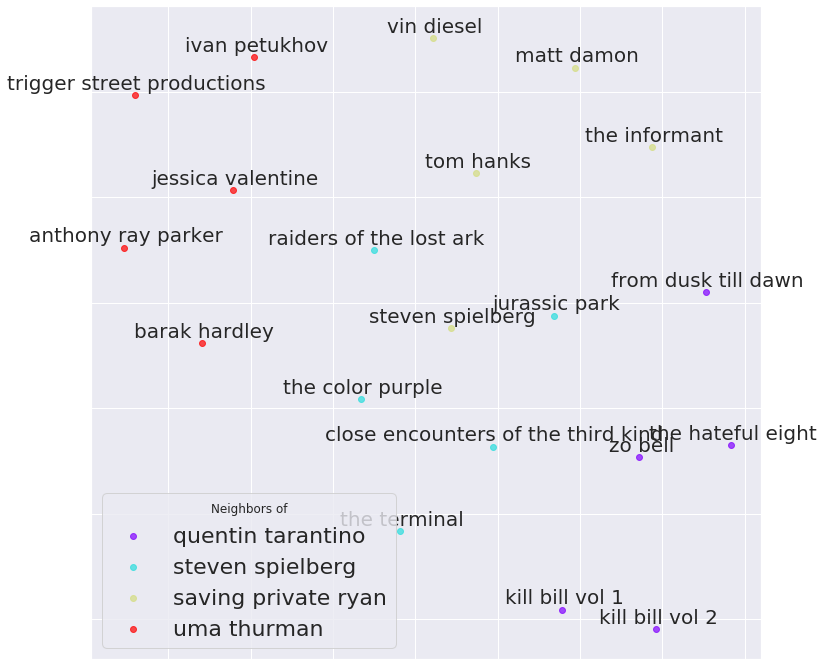

In [139]:
embedding_clusters, word_clusters = produce_clusters(model,keys)
embeddings_en_2d = produce_underdimensioned_clusters(embedding_clusters)
tsne_plot_similar_words('', tsne_keys, embeddings_en_2d, word_clusters, 0.7,
                        'tsne_new2.png')

In [84]:
model_file = 'pipeline/embeddings/imdb_movielens-sm-demo.embs'
model = models.KeyedVectors.load_word2vec_format(model_file, unicode_errors='ignore')

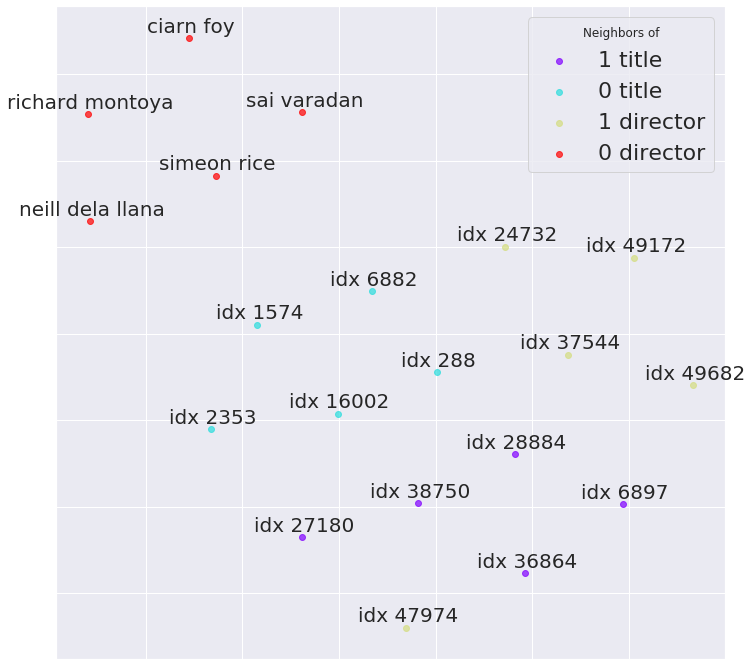

In [98]:
tsne_keys = ['1_title', '0_title', '1_director', '0_director']

embedding_clusters, word_clusters = produce_clusters(model,tsne_keys)
embeddings_en_2d = produce_underdimensioned_clusters(embedding_clusters)
tsne_plot_similar_words('', tsne_keys, embeddings_en_2d, word_clusters, 0.7,)
#                         'tsne_new2.png')

In [96]:
embeddings_en_2d

array([[[ 2004.9666  ,   723.075   ],
        [ 1311.6698  ,  1511.7152  ],
        [ 2525.598   ,  -196.54204 ],
        [ 2495.1196  ,  1735.7915  ],
        [  665.5876  ,  2342.7456  ]],

       [[-2076.5203  ,  1161.0524  ],
        [-2952.1316  ,   415.02362 ],
        [-2000.7765  ,    23.585796],
        [-2477.914   ,  -525.79346 ],
        [-1484.4746  ,  1518.5615  ]],

       [[  228.6214  ,  -662.3191  ],
        [ 1154.0245  ,  -455.89005 ],
        [  346.7951  , -1468.8345  ],
        [ 1354.907   , -1480.9727  ],
        [  341.60406 ,   117.636795]],

       [[ -390.36523 , -1004.207   ],
        [ -564.03424 ,   -97.882675],
        [ 1354.907   , -1480.9727  ],
        [-1174.7281  , -1206.1907  ],
        [ -434.83258 , -1999.3188  ]],

       [[ -564.03424 ,   -97.882675],
        [ 1062.1096  ,   519.4664  ],
        [   79.02006 ,   896.6569  ],
        [  502.65454 , -2216.67    ],
        [ 1154.0245  ,  -455.89005 ]]], dtype=float32)

In [89]:
model.vocab

{'released': <gensim.models.keyedvectors.Vocab at 0x7fc185a80940>,
 '1_title': <gensim.models.keyedvectors.Vocab at 0x7fc185a56eb8>,
 'en': <gensim.models.keyedvectors.Vocab at 0x7fc185a56978>,
 '1_actor_3': <gensim.models.keyedvectors.Vocab at 0x7fc185a56860>,
 '1_actor_2': <gensim.models.keyedvectors.Vocab at 0x7fc185a56c50>,
 '1_actor_1': <gensim.models.keyedvectors.Vocab at 0x7fc185a56748>,
 'us': <gensim.models.keyedvectors.Vocab at 0x7fc181301940>,
 '1_director': <gensim.models.keyedvectors.Vocab at 0x7fc1813015f8>,
 '6': <gensim.models.keyedvectors.Vocab at 0x7fc1813019e8>,
 'drama': <gensim.models.keyedvectors.Vocab at 0x7fc181301a58>,
 '7': <gensim.models.keyedvectors.Vocab at 0x7fc1813019b0>,
 '1_production_companies': <gensim.models.keyedvectors.Vocab at 0x7fc181301978>,
 'comedy': <gensim.models.keyedvectors.Vocab at 0x7fc181301a20>,
 '5': <gensim.models.keyedvectors.Vocab at 0x7fc181301ac8>,
 '0_title': <gensim.models.keyedvectors.Vocab at 0x7fc181301b38>,
 '8': <gensim.mo

# Operations on the vectors

Vectors generated by EmbDI can be used to carry out interesting geometric operations that rely on the geometric features of the vector space. We show here some examples. 

In [99]:
# model_file = 'pipeline/embeddings/movielens-demo.embs'
model_file = 'pipeline/experiments/movielens-demo-noidx.emb'
model = models.KeyedVectors.load_word2vec_format(model_file, unicode_errors='ignore')
df = pd.read_csv('pipeline/datasets/imdb_movielens/movielens_nospace.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'pipeline/experiments/movielens-demo-noidx.emb'

In [140]:
model_file = 'pipeline/embeddings/imdb_movielens-demo-noidx.embs'
model = models.KeyedVectors.load_word2vec_format(model_file, unicode_errors='ignore')
df = pd.read_csv('pipeline/datasets/imdb_movielens/imdb_movielens-master.csv')

## Odd one out

An interesting test consists in showing whether the connection between tokens that are related to each other is stronger than the connection between tokens belonging to the same attribute. For example, it would be interesting to see if movies that share the director or main actor are closer to each other than to other, unrelated movies.

The two cells below show this situation with Steven Spielberg and Tom Hanks: Steven Spielberg did not direct First Blood, and Tom Hanks did not star in Pulp Fiction. 

In [275]:
quiz = ['steven_spielberg', 'jaws', 'the_color_purple', 'close_encounters_of_the_third_kind', 'first_blood']
res = model.doesnt_match(quiz)
print('Given the tokens: ' + ', '.join([_.replace('_', ' ') for _ in quiz]))
print('The odd one out is: {}'.format(res.replace('_', ' ')))

Given the tokens: steven spielberg, jaws, the color purple, close encounters of the third kind, first blood
The odd one out is: first blood


In [276]:
quiz = ['tom_hanks', 'saving_private_ryan', 'toy_story', 'philadelphia', 'pulp_fiction']
res = model.doesnt_match(quiz)
print('Given the tokens: ' + ', '.join([_.replace('_', ' ') for _ in quiz]))
print('The odd one out is: {}'.format(res.replace('_', ' ')))

Given the tokens: tom hanks, saving private ryan, toy story, philadelphia, pulp fiction
The odd one out is: pulp fiction


In [207]:
quiz = ['quentin_tarantino', 'reservoir_dogs', 'django_unchained', 'pulp_fiction', 'jaws']
res = model.doesnt_match(quiz)
print('Given the tokens: ' + ', '.join([_.replace('_', ' ') for _ in quiz]))
print('The odd one out is: {}'.format(res.replace('_', ' ')))

Given the tokens: quentin tarantino, reservoir dogs, django unchained, pulp fiction, jaws
The odd one out is: jaws


In [248]:
quiz = ['reservoir_dogs', 'django_unchained', 'pulp_fiction', 'michael_douglas']
res = model.doesnt_match(quiz)
print('Given the tokens: ' + ', '.join([_.replace('_', ' ') for _ in quiz]))
print('The odd one out is: {}'.format(res.replace('_', ' ')))

Given the tokens: reservoir dogs, django unchained, pulp fiction, michael douglas
The odd one out is: michael douglas


/home/spoutnik23/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



## Querying with embeddings 

The geometric properties of the embeddings can be further exploited by performing algebraic operations using the vectors: by combining the vectors of an entity, it is possible to find entities related to it, similarly to the following example.

To find movies by director Quentin Tarantino, it is possible to add to the vector of "quentin_tarantino" the vector "title", subtracting "director". As a result, a collection of movies involving Tarantino is returned. 

In [141]:
v1 = model.get_vector('quentin_tarantino')
v2 = model.get_vector('title')
v3 = model.get_vector('director')

v_res = v1 + v2 - v3
res = print_most_similar(model, v_res, topn=50)
pprint_sim(res)

             quentin_tarantino       0.71
               kill_bill_vol_2       0.52
               kill_bill_vol_1       0.52
                  pulp_fiction       0.50
           from_dusk_till_dawn       0.49
                         title       0.48
              django_unchained       0.48
                reservoir_dogs       0.48
             the_hateful_eight       0.48
                    grindhouse       0.48
          inglourious_basterds       0.47
                   double_dare       0.47
                  jackie_brown       0.46
      my_best_friends_birthday       0.45
z_channel_a_magnificent_obsession       0.42


In [201]:
v1 = model.get_vector('steven_spielberg')
v2 = model.get_vector('title')
v3 = model.get_vector('director')

v_res = v1 + v2 - v3
res = print_most_similar(model, v_res, topn=50)
pprint_sim(res)

                                                      steven_spielberg       0.73
                                               raiders_of_the_lost_ark       0.53
                                                         jurassic_park       0.51
                                                                 title       0.51
                                                      the_color_purple       0.50
                                    close_encounters_of_the_third_kind       0.49
                                                                  jaws       0.49
                                                             war_horse       0.48
                                                          the_terminal       0.48
                                    indiana_jones_and_the_last_crusade       0.47
                                                         night_gallery       0.46
                                                   saving_private_ryan       0.46
                

In [142]:
res = [_[0].replace('tt__', '') for _ in res]
display(df.loc[df['title'].isin(res), ['title', 'director', 'actor_1', 'actor_2', 'actor_3']].head())

,title,director,actor_1,actor_2,actor_3
285,django_unchained,quentin_tarantino,leonardo_dicaprio,christoph_waltz,ato_essandoh
568,inglourious_basterds,quentin_tarantino,michael_fassbender,brad_pitt,christoph_waltz
681,the_hateful_eight,quentin_tarantino,craig_stark,jennifer_jason_leigh,zo_bell
824,kill_bill_vol_1,quentin_tarantino,david_carradine,vivica_a_fox,chiaki_kuriyama
826,kill_bill_vol_2,quentin_tarantino,vivica_a_fox,michael_parks,michael_bowen


It is also possible to find those movies that do not star an actor, for example, as in the following case.

We subtract the vector for "samuel_l._jackson" from "quentin_tarantino", while adding "title" to obtain movies by Tarantino that do not star Samuel L. Jackson. 

In [279]:
v1 = model.get_vector('quentin_tarantino')
v2 = model.get_vector('title')
v3 = model.get_vector('samuel_l_jackson')

v_res = v1 + v2 - v3
res = f(v_res, topn=15)
print([_[0] for _ in res])

display(df.loc[df['title'].isin([_[0] for _ in res]), ['title', 'director', 'actor_1', 'actor_2', 'actor_3']])

['quentin_tarantino', 'title', 'from_dusk_till_dawn', 'kill_bill_vol_2', 'double_dare', 'my_best_friends_birthday', 'inglourious_basterds', 'django_unchained', 'reservoir_dogs', 'mean_streets', 'sicko', 'interview_with_the_vampire_the_vampire_chronicles', 'shaun_of_the_dead', 'subconscious', 'kill_bill_vol_1']


,title,director,actor_1,actor_2,actor_3
285,django_unchained,quentin_tarantino,leonardo_dicaprio,christoph_waltz,ato_essandoh
568,inglourious_basterds,quentin_tarantino,michael_fassbender,brad_pitt,christoph_waltz
824,kill_bill_vol_1,quentin_tarantino,david_carradine,vivica_a_fox,chiaki_kuriyama
826,kill_bill_vol_2,quentin_tarantino,vivica_a_fox,michael_parks,michael_bowen
908,interview_with_the_vampire_the_vampire_chronicles,neil_jordan,brad_pitt,tom_cruise,kirsten_dunst
1237,mean_streets,martin_scorsese,robert_de_niro,david_carradine,david_proval
2158,from_dusk_till_dawn,robert_rodriguez,quentin_tarantino,salma_hayek,cheech_marin
3120,sicko,michael_moore,michael_moore,tucker_albrizzi,bill_clinton
3518,shaun_of_the_dead,edgar_wright,peter_serafinowicz,dylan_moran,rafe_spall
4145,reservoir_dogs,quentin_tarantino,quentin_tarantino,steve_buscemi,chris_penn


[Text(0, 0.5, 'quentin\ntarantino'),
 Text(0, 1.5, 'title'),
 Text(0, 2.5, 'pulp\nfiction'),
 Text(0, 3.5, 'django\nunchained'),
 Text(0, 4.5, 'quentin\ntarantino\n+title\n-director')]

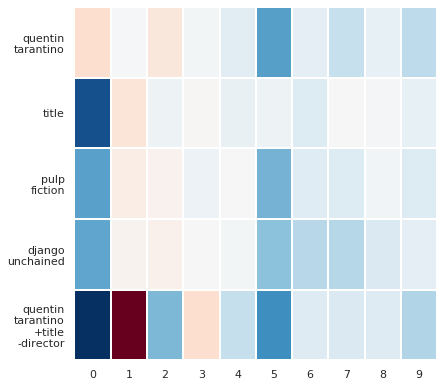

In [252]:
values = ['quentin_tarantino','title', 'pulp_fiction', 'django_unchained']

k = []
for _ in values:
    k.append(keys.index(_))

m = mat[k,:]

array_title = mat[keys.index('title')]
array_director_name = mat[keys.index('quentin_tarantino')]
array_director = mat[keys.index('director')]
array_sum = array_title+array_director_name-array_director
values.append('quentin_tarantino\n+title\n-director')
labels = [_.replace('_', '\n') if len(_) > 10 else _.replace('_', ' ') for _ in values]
m = np.concatenate((m, array_sum.reshape((1,10))), axis=0)

fig = plt.figure(figsize=(6.5, 6.5))
g = sns.heatmap(data=m, cmap='RdBu', cbar=False, linewidths=1)
g.set_yticklabels(labels=labels,rotation=0)

Finally, we can query the vector space for an actor name and look for names related to them. Here, 'arnold_schwarzenegger' is close to 'wilt_chamberlain', 'james_cameron' and 'deborah_loomis'. Chamberlain and Loomis both starred in action movies with Schawrzenegger, while James Cameron directed the Terminator movies, which Schwarzenegger starred in. 

In [280]:
a = 'arnold_schwarzenegger'
r = model.most_similar(a, topn=20)
r = [_[0] for _ in r]
actor1 = set(df['actor_1'].tolist() + df['actor_2'].tolist() + df['actor_3'].tolist())
[_ for _ in r if _ in actor1]

['wilt_chamberlain', 'james_cameron', 'deborah_loomis']

In [129]:
model_file = 'pipeline/embeddings/imdb_movielens-demo.emb'
model = models.KeyedVectors.load_word2vec_format(model_file, unicode_errors='ignore')
df = pd.read_csv('pipeline/datasets/imdb_movielens/imdb_movielens-master.csv')

In [196]:
'a clockwork orange'
'2001_a_space_odyssey'
'the_lord_of_the_rings_the_fellowship_of_the_ring'
'saving_private_ryan'
'inception'
'interstellar'
'your_name'
'the_shawshank_redemption'
'the_godfather'
'reservoir_dogs'
'inglourious_basterds'
'jurassic_park'
'jurassic_world'
'jaws'
'american_graffiti'
'star_wars'
'the_empire_strikes_back'
'pulp_fiction'

'star_wars'

In [239]:
test_name = 'pulp_fiction'
v1 = model.get_vector(test_name)
v2 = model.get_vector('title')
v3 = v1 - v2
r = model.similar_by_vector(v3)
pprint_sim(r)
display(df1.loc[df1['title'] == test_name.replace('_', ' ')].reindex(['actor 1', 'actor 2', 'actor 3', 'director', 'title', 'year'], axis=1))
display(df2.loc[df2['title'] == test_name.replace('_', ' ')].reindex(['actor 1', 'actor 2', 'actor 3', 'director', 'title', 'year'], axis=1))

                                                          pulp_fiction       0.79
                                                     quentin_tarantino       0.42
                                                                199409       0.37
                                                           phil_lamarr       0.36
                                                                clerks       0.31
                                                          bruce_willis       0.31
                                                         jeff_anderson       0.31
                                                           eric_stoltz       0.31
                                                        brian_a_miller       0.30
                                                           alannah_ong       0.29


,actor 1,actor 2,actor 3,director,title,year
3178,bruce willis,eric stoltz,phil lamarr,quentin tarantino,pulp fiction,1994.0


,actor 1,actor 2,actor 3,director,title,year
292,john travolta,samuel l. jackson,uma thurman,quentin tarantino,pulp fiction,1994


## Additional tests

In [209]:
model_file = 'pipeline/embeddings/imdb_movielens-demo.embs'
m1 = models.KeyedVectors.load_word2vec_format(model_file, unicode_errors='ignore')
df = pd.read_csv('pipeline/datasets/imdb_movielens/imdb_movielens-master.csv')

In [210]:
m1.most_similar('idx_0')

[('idx_19069', 0.8253809213638306),
 ('idx_1189', 0.7232210636138916),
 ('idx_1088', 0.7182182669639587),
 ('idx_294', 0.7120844125747681),
 ('idx_352', 0.7058795690536499),
 ('idx_2533', 0.6957617998123169),
 ('idx_2182', 0.6908314824104309),
 ('idx_774', 0.6885037422180176),
 ('idx_278', 0.6877021193504333),
 ('avatar', 0.6872022151947021)]

In [204]:
df.loc[df['title'] == 'avatar']

,actor_1,actor_2,actor_3,color,content_rating,director,genres,original_language,production_companies,production_countries,release_date_rounded,status,title,vote_average,year
0,cch_pounder,joel_david_moore,wes_studi,color,pg13,james_cameron,NaN,english,NaN,usa,NaN,NaN,avatar,8.0,2009.0
19069,sam_worthington,zoe_saldana,sigourney_weaver,NaN,NaN,james_cameron,action,en,ingenious|film|partners,us,200912.0,released,avatar,7.0,2009.0


In [221]:
i1 = 2321
i2 = 20572
v1 = df.iloc[i1]['title']
v2 = df.iloc[i2]['title']
print('Line {} has title {}.\nLine {} has title {}.'.format(i1,v1,i2,v2))
print()
i1 = 251
i2 = 27416
v1 = df.iloc[i1]['title']
v2 = df.iloc[i2]['title']
print('Line {} has title {}.\nLine {} has title {}.'.format(i1,v1,i2,v2))


Line 2321 has title 127_hours.
Line 20572 has title 127_hours.

Line 251 has title 300_rise_of_an_empire.
Line 27416 has title 300_rise_of_an_empire.


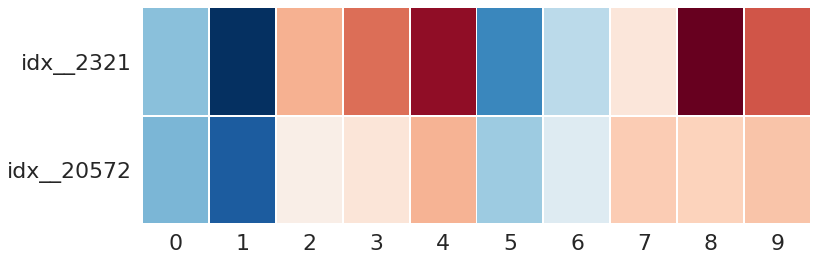

In [247]:
values = ['idx__2321', 'idx__20572']
# labels = [_.replace('idx__', '') for _ in values]
labels = values

k = []
for _ in values:
    k.append(keys.index(_))

fig = plt.figure(figsize=(12,4))
sns.set(font_scale=2)
g = sns.heatmap(data=mat[k, :], cmap='RdBu', cbar=False, linewidths=1, square=False)
g.set_yticklabels(labels=labels, rotation=0)
fig.savefig('entity_resolution.png', bbox_inches='tight')

In [243]:
df.loc[df['title'] == 'pulp_fiction']

,actor_1,actor_2,actor_3,color,content_rating,director,genres,original_language,production_companies,production_countries,release_date_rounded,status,title,vote_average,year
3178,bruce_willis,eric_stoltz,phil_lamarr,color,r,quentin_tarantino,NaN,english,NaN,usa,NaN,NaN,pulp_fiction,9.0,1994.0
4821,john_travolta,samuel_l_jackson,uma_thurman,NaN,NaN,quentin_tarantino,thriller,en,miramax|films,us,199409.0,released,pulp_fiction,8.0,1994.0


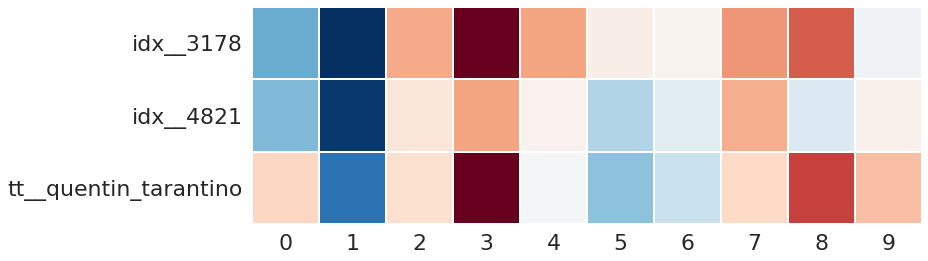

In [245]:
values = ['idx__3178', 'idx__4821', 'tt__quentin_tarantino']
# labels = [_.replace('idx__', '') for _ in values]
labels = values

k = []
for _ in values:
    k.append(keys.index(_))

fig = plt.figure(figsize=(12,4))
sns.set(font_scale=2)
g = sns.heatmap(data=mat[k, :], cmap='RdBu', cbar=False, linewidths=1, square=False)
g.set_yticklabels(labels=labels, rotation=0)
fig.savefig('entity_resolution.png', bbox_inches='tight')

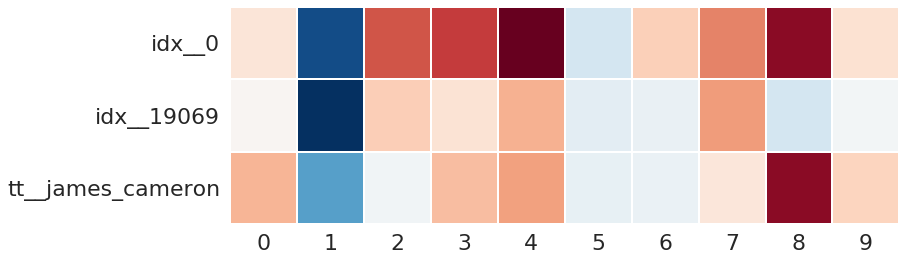

In [238]:
values = ['idx__0', 'idx__19069', 'tt__james_cameron']
# labels = [_.replace('idx__', '') for _ in values]
labels = values

k = []
for _ in values:
    k.append(keys.index(_))

fig = plt.figure(figsize=(12,4))
sns.set(font_scale=2)
g = sns.heatmap(data=mat[k, :], cmap='RdBu', cbar=False, linewidths=1, square=False)
g.set_yticklabels(labels=labels, rotation=0)
fig.savefig('entity_resolution.png', bbox_inches='tight')